## Hardware specs

In [ ]:
!nvidia-smi -L
!lscpu

GPU 0: Tesla T4 (UUID: GPU-570c3707-fcce-e4b4-9ed7-0edd135758d9)
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.200
BogoMIPS:            4000.40
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsav

## Environment

In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import time
from torchvision import datasets, models, transforms
from pathlib import Path
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
!mkdir data
data_dir = Path('./data')
net_fn = Path('./net')

torch.manual_seed(0)
np.random.seed(0)

PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116


## Set up dataloader

In [ ]:
# Mount data directory to google drive
from google.colab import drive
drive.mount('./drive')

# Copy to local for faster extraction
# !cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_img_val.tar ./data
# !cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_devkit_t3.tar.gz ./data
# !cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_devkit_t12.tar.gz ./data
!cp drive/MyDrive/ese-5390-files/ILSVRC2012_img_val.tar ./data
!cp drive/MyDrive/ese-5390-files/ILSVRC2012_devkit_t3.tar.gz ./data
!cp drive/MyDrive/ese-5390-files/ILSVRC2012_devkit_t12.tar.gz ./data

# Create transform to preprocess data
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create validation dataset
val_dataset = datasets.ImageNet('./data', split='val', transform=val_transform)

val_dataloader = torch.utils.data.DataLoader(val_dataset, num_workers=4)

print(f'Number of validation images: {len(val_dataset)}')

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).
Number of validation images: 50000


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Define functions

In [ ]:
# Get weights of pretrained model and instantiate model
model = models.resnet50(pretrained=True)

# Populate dictionary with pretrained models
my_models = {
    'alexnet': {model: models.alexnet(pretrained=True)},
    'googlenet': {model: models.googlenet(pretrained=True)},
    'vgg16': {model: models.vgg16(pretrained=True)},
    'resnet50': {model: models.resnet50(pretrained=True)}
}

def validate_model(model, dataloader, device="cpu", n=None):
    model.eval()
    running_corrects = 0
    total = 0

    # Move model to device (CPU or GPU)
    # One time to amortize data movement
    dev = torch.device(device)
    model.to(dev)

    # Iterate over data stopping early if n is set
    for i, (inputs, labels) in enumerate(dataloader):
        if (n is not None and i >= n):
            break
        # Send inputs to device
        inputs = inputs.to(dev)
        labels = labels.to(dev)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Gather statistics
        running_corrects += torch.sum(predicted == labels.data)
        total += inputs.size()[0]       # get batch size

        if i % 200 == 199:
            acc = 100 * running_corrects.double() / total
            print(f'[{i + 1}] {acc:.4f}%')

    epoch_acc = 100 * running_corrects.double() / total

    return epoch_acc

def benchmark_inference(model, dataloader, n=None, trials=5, warmup=10, device="cpu"):
    """ n = Number of inferences, trials = number of trials, warmup = number of warmup trials, device="cpu" or "cuda" """
    # TODO Implement
    validate_model(model, dataloader, device=device, n=warmup)
    start_time = time.time()
    for i in range(trials):
        validate_model(model, dataloader, device=device, n=n)
    torch.cuda.synchronize()
    end_time = time.time()
    return (end_time - start_time)/trials # TODO Return inference time in seconds

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

## Disable cuDNN

In [ ]:
torch.backends.cudnn.enabled = False

## Run inferences

In [ ]:
for item in my_models.items():
    runtime = benchmark_inference(item[1][model], val_dataloader, n=1024, trials=5, warmup=10, device="cuda")
    print(f'{item[0]} -- GPU Runtime: {runtime}')
    my_models[item[0]]['gpu_benchmark'] = {1: runtime}

[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
alexnet -- GPU Runtime: 10.821551418304443
[200] 82.5000%
[400] 77.7500%
[600] 81.5000%
[800] 83.2500%
[1000] 83.3000%
[200] 82.5000%
[400] 77.7500%
[600] 81.5000%
[800] 83.2500%
[1000] 83.3000%
[200] 82.5000%
[400] 77.7500%
[600] 81.5000%
[800] 83.2500%
[1000] 83.3000%
[200] 82.5000%
[400] 77.7500%
[600] 81.5000%
[800] 83.2500%
[1000] 83.3000%
[200] 82.5000%
[400] 77.7500%
[600] 81.5000%
[800] 83.2500%
[1000] 83.3000%
googlenet -- GPU Runtime: 20.85661554336548
[200] 85.5000%
[400] 82.0000%
[600] 84.8333%
[800] 87.0000%
[1000] 87.4000%
[200] 85.5000%
[400] 82.0000%
[600] 84.8333%
[800] 87.0000%
[1000] 87.4000%
[

## Plot results

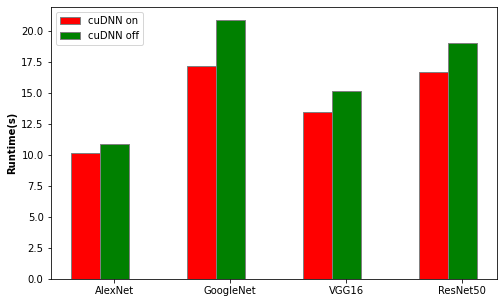

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(8, 5))

# set height of bar
cudnn_on = [10.156299686431884,17.1785927772522,13.446695375442506,16.661205291748047]
cudnn_off = [10.821551418304443,20.85661554336548,15.101460886001586,19.0075599193573]

# Set position of bar on X axis
br1 = np.arange(len(cudnn_on))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, cudnn_on, color ='r', width = barWidth,
		edgecolor ='grey', label ='cuDNN on')
plt.bar(br2, cudnn_off, color ='g', width = barWidth,
		edgecolor ='grey', label ='cuDNN off')

# Adding Xticks
plt.ylabel('Runtime(s)', fontweight ='bold', fontsize = 10)
plt.xticks([r + barWidth for r in range(len(cudnn_on))],
		['AlexNet', 'GoogleNet', 'VGG16', 'ResNet50'])

plt.legend()
plt.show()
